In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, plot_tree
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
import pickle
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import learning_curve

# Using same model as used for Taxi Data

In [2]:
df = pd.read_csv('subway_Data_Final.csv')

/var/folders/8v/myv9ql5d1lg4ct7vbb0zh8000000gn/T/ipykernel_68479/2106810974.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('subway_Data_Final.csv')


In [3]:
df['month'].unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1])

In [4]:
df.drop(columns=['ridership'], inplace=True)
df.drop(columns=['latitude'], inplace=True)
df.drop(columns=['longitude'], inplace=True)


**Convert data types**

In [5]:
df.dtypes

station_complex_id    object
year                   int64
month                  int64
day                    int64
hour                   int64
busyness_rank          int64
dtype: object

In [6]:
df['month'].unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1])

In [7]:
df.to_csv('subway_data.csv', index=False)

In [8]:
df['month'].unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1])

In [9]:
df['station_complex_id'].unique()

array([8, 9, 10, 13, 14, 16, 17, 20, 22, 103, 107, 118, 119, 143, 144,
       145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 162, 164, 165, 167, 168, 169, 220, 222, 223, 224, 225,
       228, 231, 232, 234, 276, 277, 296, 297, 298, 299, 300, 301, 303,
       304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 316, 318,
       319, 320, 321, 323, 324, 325, 326, 327, 328, 329, 333, 392, 393,
       394, 395, 396, 397, 398, 399, 403, 404, 405, 407, 409, 413, 414,
       436, 437, 438, 439, 440, 441, 471, 475, 476, 477, 601, 602, 605,
       607, 609, 610, 611, 612, 613, 614, 618, 619, 622, 623, 624, 625,
       628, 635, '618', '619', '622', '623', '624', '625', '628', '635',
       '8', '9', 'TRAM1', 'TRAM2'], dtype=object)

In [10]:
mapping = {'TRAM1': 1, 'TRAM2': 2}
df['station_complex_id'] = df['station_complex_id'].replace(mapping)

df['station_complex_id'] = df['station_complex_id'].astype('category')
df['day'] = df['day'].astype('category')
df['hour'] = df['hour'].astype('category')
df['year'] = df['year'].astype('category')
df['month'] = df['month'].astype('category')

In [11]:
df['month'].unique()

[2, 3, 4, 5, 6, ..., 9, 10, 11, 12, 1]
Length: 12
Categories (12, int64): [1, 2, 3, 4, ..., 9, 10, 11, 12]

**Split data using a 30% test 70% train split**

In [12]:
df['station_complex_id'].unique()

[8, 9, 10, 13, 14, ..., '635', '8', '9', 1, 2]
Length: 133
Categories (133, object): [1, 2, 8, 9, ..., '628', '635', '8', '9']

In [13]:
X = df.drop(columns=['busyness_rank'])
y = df['busyness_rank']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**Weighted Data**

In [14]:
df_weighted = df

for i in range(5):
    df_weighted[f'station_complex_id_dup_{i}'] = df_weighted['station_complex_id']

In [15]:
X_weighted = df_weighted.drop(columns=['busyness_rank'])
y_weighted = df_weighted['busyness_rank']

X_train_weighted, X_test_weighted, y_train_weighted, y_test_weighted = train_test_split(X_weighted, y_weighted, test_size=0.3, random_state=42)

**Define ranks for displaying metrics**

In [16]:
ranks = ['1 (busiest)', '2', '3', '4', '5 (quietest)']

**Evaluation Function**

In [17]:
def evaluate_model(y_test, y_pred):
    """
    Evaluates a classification model and prints key metrics.
    
    Parameters:
    y_test (array-like): True labels
    y_pred (array-like): Predicted labels
    """
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=ranks)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.title('Confusion Matrix')
    plt.show()
    
    class_report = classification_report(y_test, y_pred, output_dict=True)
    class_report_df = pd.DataFrame(class_report).transpose()

    print("\nClassification Report:")
    print(class_report_df)

# 3. Random Forest
### Original Data

In [18]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

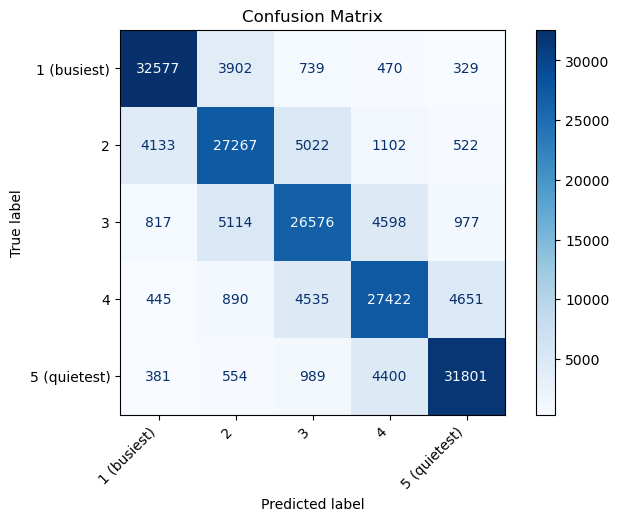


Classification Report:
              precision    recall  f1-score        support
1              0.849399  0.856906  0.853136   38017.000000
2              0.722745  0.716685  0.719702   38046.000000
3              0.701936  0.697863  0.699893   38082.000000
4              0.721784  0.722716  0.722249   37943.000000
5              0.830747  0.834125  0.832432   38125.000000
accuracy       0.765684  0.765684  0.765684       0.765684
macro avg      0.765322  0.765659  0.765483  190213.000000
weighted avg   0.765348  0.765684  0.765508  190213.000000


In [19]:
y_pred_rf = rf.predict(X_test)

evaluate_model(y_test, y_pred_rf)

### Weighted Data

In [20]:
rf.fit(X_train_weighted, y_train_weighted)

RandomForestClassifier(random_state=42)

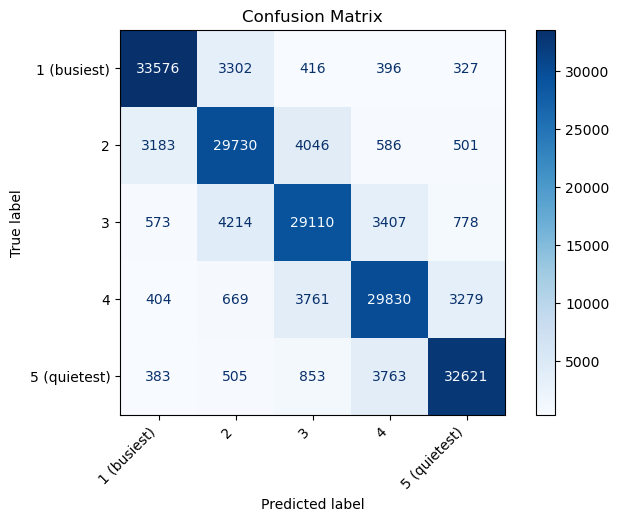


Classification Report:
              precision    recall  f1-score        support
1              0.880821  0.883184  0.882001   38017.000000
2              0.773816  0.781422  0.777601   38046.000000
3              0.762321  0.764403  0.763361   38082.000000
4              0.785372  0.786179  0.785775   37943.000000
5              0.869754  0.855633  0.862636   38125.000000
accuracy       0.814177  0.814177  0.814177       0.814177
macro avg      0.814417  0.814164  0.814275  190213.000000
weighted avg   0.814435  0.814177  0.814290  190213.000000


In [21]:
y_weighted_pred_rf = rf.predict(X_test_weighted)

evaluate_model(y_test_weighted, y_weighted_pred_rf)

# XGBoost
### Original Data  
**Must be adjusted to represent [0, 1, 2, 3, 4]**

In [22]:
y_adjusted = y - 1
X_train_adjusted, X_test_adjusted, y_train_adjusted, y_test_adjusted = train_test_split(X, y_adjusted, test_size=0.2, random_state=42)

In [23]:
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42, enable_categorical=True)
xgb.fit(X_train_adjusted, y_train_adjusted)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

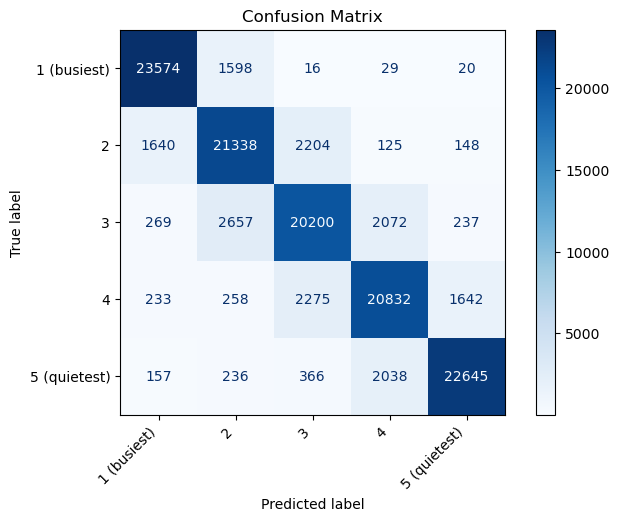


Classification Report:
              precision    recall  f1-score        support
0              0.911143  0.934105  0.922481   25237.000000
1              0.817955  0.838264  0.827985   25455.000000
2              0.806033  0.794181  0.800063   25435.000000
3              0.830092  0.825357  0.827718   25240.000000
4              0.917099  0.890064  0.903379   25442.000000
accuracy       0.856319  0.856319  0.856319       0.856319
macro avg      0.856465  0.856394  0.856325  126809.000000
weighted avg   0.856417  0.856319  0.856264  126809.000000


In [24]:
y_pred_xgb = xgb.predict(X_test_adjusted)

evaluate_model(y_test_adjusted, y_pred_xgb)

In [25]:
with open('subway_xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb, file)

### Weighted Data

In [26]:
y_weighted_adjusted = y_weighted - 1

X_train_weighted_adjusted, X_test_weighted_adjusted, y_train_weighted_adjusted, y_test_weighted_adjusted = train_test_split(X_weighted, y_weighted_adjusted, test_size=0.3, random_state=42)

In [27]:
xgb.fit(X_train_weighted_adjusted, y_train_weighted_adjusted)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

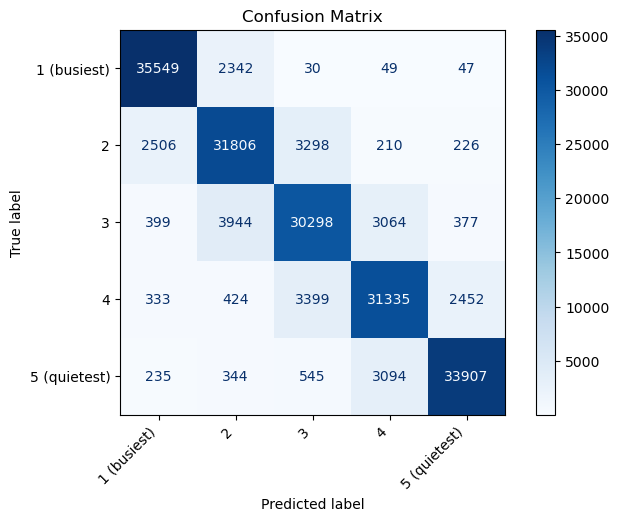


Classification Report:
              precision    recall  f1-score        support
0              0.910999  0.935082  0.922883   38017.000000
1              0.818477  0.835988  0.827140   38046.000000
2              0.806441  0.795599  0.800983   38082.000000
3              0.830022  0.825844  0.827928   37943.000000
4              0.916183  0.889364  0.902574   38125.000000
accuracy       0.856382  0.856382  0.856382       0.856382
macro avg      0.856424  0.856375  0.856302  190213.000000
weighted avg   0.856446  0.856382  0.856316  190213.000000


In [28]:
y_pred_weighted_xgb = xgb.predict(X_test_weighted_adjusted)

evaluate_model(y_test_weighted_adjusted, y_pred_weighted_xgb)

# Ensemble (rf, xgboost)

In [29]:
rf.fit(X_train_adjusted, y_train_adjusted)
xgb.fit(X_train_adjusted, y_train_adjusted)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [30]:
ensemble = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='soft')
ensemble.fit(X_train_adjusted, y_train_adjusted)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...))],
                 voting='soft')

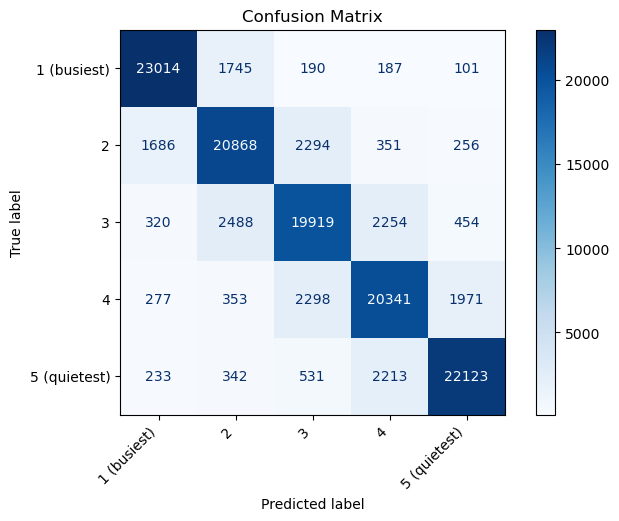


Classification Report:
              precision    recall  f1-score        support
0              0.901449  0.911915  0.906652   25237.000000
1              0.808963  0.819800  0.814345   25455.000000
2              0.789434  0.783133  0.786271   25435.000000
3              0.802533  0.805903  0.804215   25240.000000
4              0.888296  0.869546  0.878821   25442.000000
accuracy       0.837993  0.837993  0.837993       0.837993
macro avg      0.838135  0.838060  0.838061  126809.000000
weighted avg   0.838089  0.837993  0.838004  126809.000000


In [31]:
y_pred_ensemble = ensemble.predict(X_test_adjusted)
evaluate_model(y_test_adjusted, y_pred_ensemble)

### Feature Importance

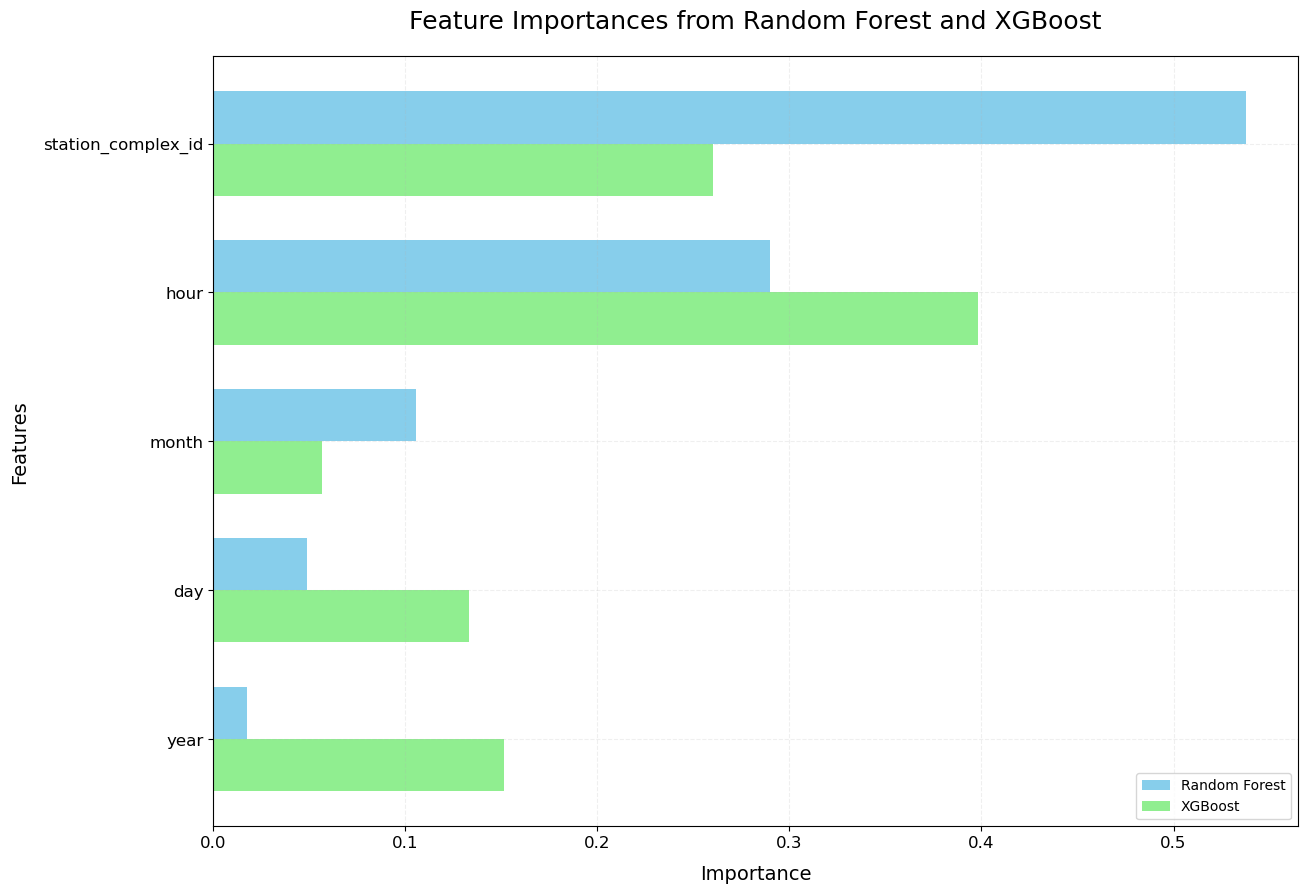

In [32]:
rf_importances = rf.feature_importances_
xgb_importances = xgb.feature_importances_

rf_importance_df = pd.DataFrame({
    'Feature': X_train_adjusted.columns,
    'RF_Importance': rf_importances
}).sort_values(by='RF_Importance', ascending=False)

xgb_importance_df = pd.DataFrame({
    'Feature': X_train_adjusted.columns,
    'XGB_Importance': xgb_importances
}).sort_values(by='XGB_Importance', ascending=False)

importance_df = pd.merge(rf_importance_df, xgb_importance_df, on='Feature')
importance_df.set_index('Feature', inplace=True)

fig, ax = plt.subplots(figsize=(14, 10))
bar_width = 0.35
index = np.arange(len(importance_df))

bar1 = ax.barh(index, importance_df['RF_Importance'], bar_width, label='Random Forest', color='skyblue')
bar2 = ax.barh(index + bar_width, importance_df['XGB_Importance'], bar_width, label='XGBoost', color='lightgreen')

ax.set_xlabel('Importance', fontsize=14, labelpad=10, color='black')
ax.set_ylabel('Features', fontsize=14, labelpad=10, color='black')
ax.set_title('Feature Importances from Random Forest and XGBoost', fontsize=18, pad=20)
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(importance_df.index, fontsize=12)
ax.invert_yaxis()  # Highest importance at the top
ax.grid(True, linestyle='--', alpha=0.2)
ax.legend(loc="lower right", fontsize=10)

plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')
plt.show()

# Stacking

In [33]:
base_models = [
    ('rf', rf),
    ('xgb', xgb)
]

meta_model = LogisticRegression()

stacking = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=3)
stacking.fit(X_train_adjusted, y_train_adjusted)

StackingClassifier(cv=3,
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=True,
                                              eval_metric='mlogloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              im...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softprob', ...))],
                   final_estimator=LogisticRegression())

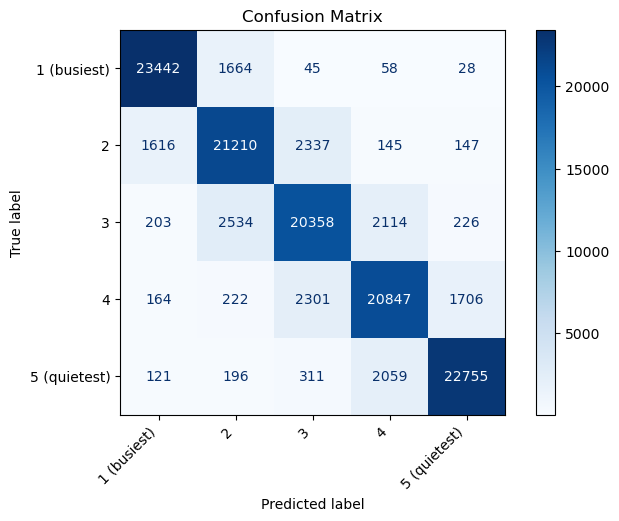


Classification Report:
              precision    recall  f1-score        support
0              0.917639  0.928874  0.923222   25237.000000
1              0.821265  0.833235  0.827207   25455.000000
2              0.803014  0.800393  0.801701   25435.000000
3              0.826508  0.825951  0.826229   25240.000000
4              0.915252  0.894387  0.904699   25442.000000
accuracy       0.856501  0.856501  0.856501       0.856501
macro avg      0.856735  0.856568  0.856612  126809.000000
weighted avg   0.856685  0.856501  0.856553  126809.000000


In [34]:
y_pred_stacking = stacking.predict(X_test_adjusted)

evaluate_model(y_test_adjusted, y_pred_stacking)

In [35]:
with open('subway_stacking_model.pkl', 'wb') as file:
    pickle.dump(stacking, file)

In [36]:
X_test_adjusted

,station_complex_id,year,month,day,hour
370074,296,2023,1,6,12
214636,628,2022,10,2,14
240598,13,2024,3,0,12
199175,613,2022,6,2,3
426600,313,2024,6,1,4
...,...,...,...,...,...
394532,305,2023,2,4,10
519885,414,2023,1,1,16
583182,613,2023,10,4,13
550897,477,2023,6,6,9


In [37]:
scoring = 'accuracy'

# Use learning_curve to get training and test scores
train_sizes, train_scores, test_scores = learning_curve(
    stacking, X_train_adjusted, y_train_adjusted, cv=3, scoring=scoring,
    train_sizes=np.linspace(0.1, 1.0, 5), verbose=1
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


[learning_curve] Training set sizes: [ 33815 109900 185985 262070 338155]


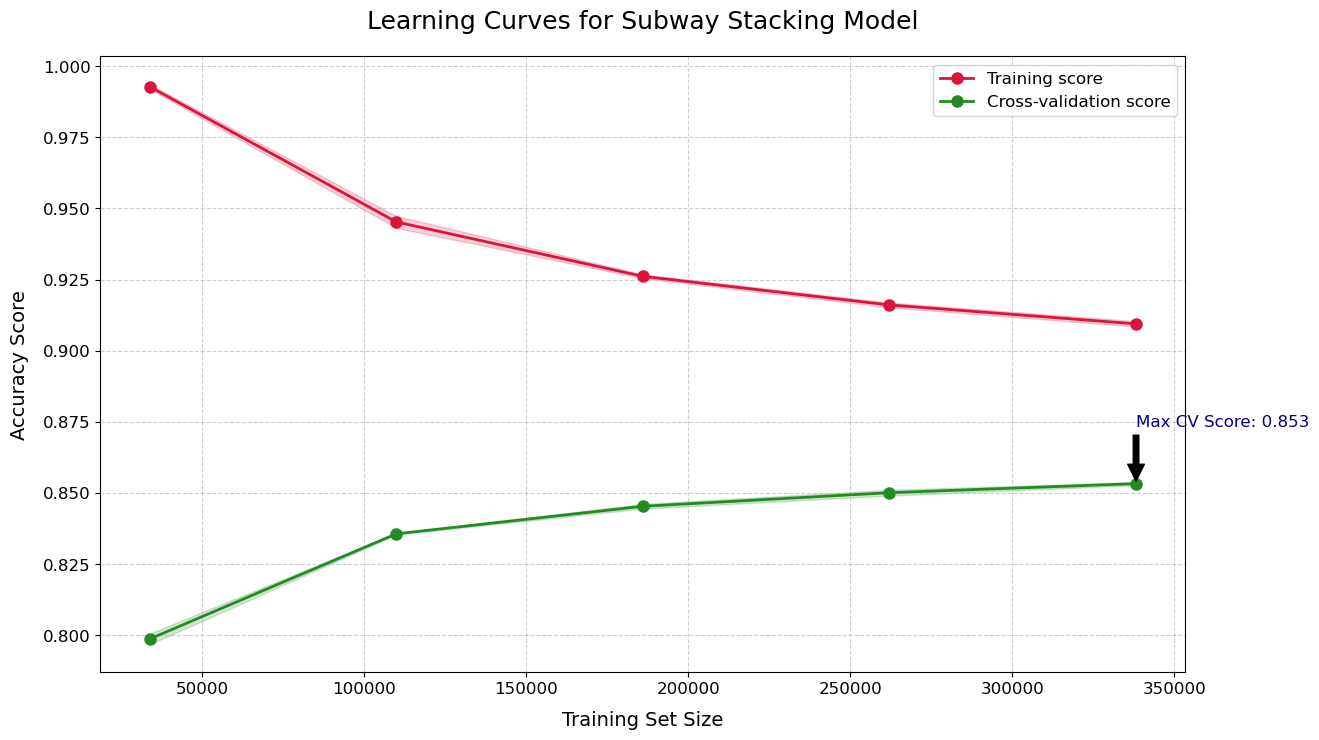

In [38]:
plt.figure(figsize=(14, 8))

# Training score
plt.plot(train_sizes, train_scores_mean, 'o-', color="crimson", label="Training score", linewidth=2, markersize=8)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="crimson")

# Cross-validation score
plt.plot(train_sizes, test_scores_mean, 'o-', color="forestgreen", label="Cross-validation score", linewidth=2, markersize=8)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="forestgreen")

max_train_size = train_sizes[np.argmax(test_scores_mean)]
max_test_score = max(test_scores_mean)
min_test_score = min(test_scores_mean)
plt.annotate(f'Max CV Score: {max_test_score:.3f}', xy=(max_train_size, max_test_score), xytext=(max_train_size, max_test_score+0.02),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color="darkblue")

plt.xlabel('Training Set Size', fontsize=14, labelpad=10)
plt.ylabel('Accuracy Score', fontsize=14, labelpad=10)
plt.title('Learning Curves for Subway Stacking Model', fontsize=18, pad=20)
plt.legend(loc="best", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)



plt.show()

In [39]:
scoring = 'accuracy'

# Use learning_curve to get training and test scores
train_sizes, train_scores, test_scores = learning_curve(
    xgb, X_train_adjusted, y_train_adjusted, cv=3, scoring=scoring,
    train_sizes=np.linspace(0.1, 1.0, 5), verbose=1
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


[learning_curve] Training set sizes: [ 33815 109900 185985 262070 338155]


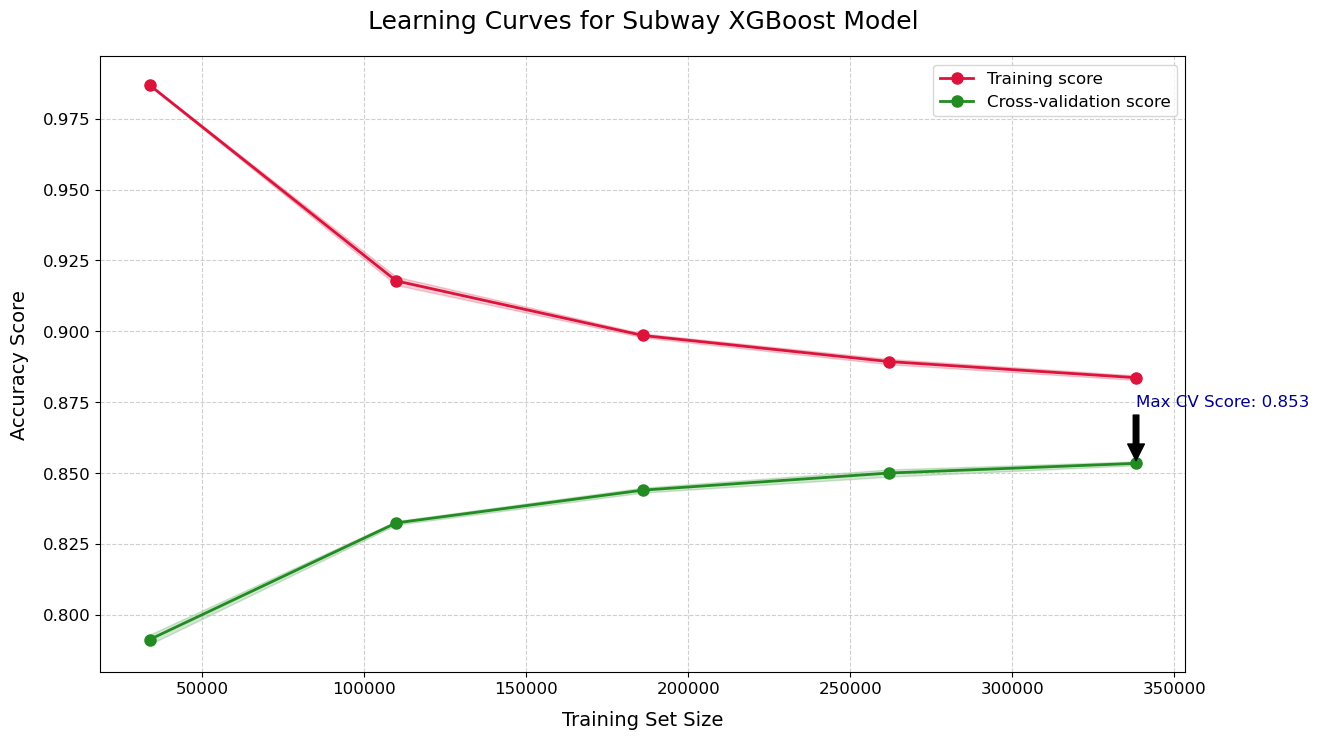

In [40]:
plt.figure(figsize=(14, 8))

# Training score
plt.plot(train_sizes, train_scores_mean, 'o-', color="crimson", label="Training score", linewidth=2, markersize=8)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="crimson")

# Cross-validation score
plt.plot(train_sizes, test_scores_mean, 'o-', color="forestgreen", label="Cross-validation score", linewidth=2, markersize=8)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="forestgreen")

max_train_size = train_sizes[np.argmax(test_scores_mean)]
max_test_score = max(test_scores_mean)
min_test_score = min(test_scores_mean)
plt.annotate(f'Max CV Score: {max_test_score:.3f}', xy=(max_train_size, max_test_score), xytext=(max_train_size, max_test_score+0.02),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color="darkblue")

plt.xlabel('Training Set Size', fontsize=14, labelpad=10)
plt.ylabel('Accuracy Score', fontsize=14, labelpad=10)
plt.title('Learning Curves for Subway XGBoost Model', fontsize=18, pad=20)
plt.legend(loc="best", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)



plt.show()